In [ ]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint as torch_odeint 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


CSV_FILENAME = "C9_zoomed_interpolated.csv" 


LEARNING_RATE = 1e-3 
NUM_EPOCHS = 5000  
HIDDEN_DIM_NN = 32
ODE_SOLVER = 'dopri5'
PRINT_EVERY = 100
WEIGHT_DECAY = 1e-6


print(f"\n--- Loading Empirical Data from {CSV_FILENAME} ---")
try:
    df = pd.read_csv(CSV_FILENAME)
    print("CSV loaded successfully.")
    print("Columns:", df.columns.tolist())
except FileNotFoundError:
    print(f"Error: File not found at {CSV_FILENAME}")
    print("Please ensure the CSV file is in the correct directory.")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()


print("\n--- Preparing and Splitting Data (80% Train, 20% Test) ---")


time_col = 'time (days)'
prey_col = 'algae (10^6 cells/ml)' 
predator_col = 'rotifers (animals/ml)' 

if not all(col in df.columns for col in [time_col, prey_col, predator_col]):
     print(f"Error: Required columns ('{time_col}', '{prey_col}', '{predator_col}') not found in CSV.")
     print("Available columns:", df.columns.tolist())
     exit()


t_data_np_full = df[time_col].values.astype(np.float32)
u_data_np_full = df[[prey_col, predator_col]].values.astype(np.float32) 

N_POINTS = len(t_data_np_full)
if N_POINTS < 2:
    print("Error: Not enough data points loaded from CSV.")
    exit()
print(f"Loaded {N_POINTS} data points.")


split_ratio = 0.8
split_idx = int(split_ratio * N_POINTS)
n_train = split_idx
n_test = N_POINTS - n_train

if n_train < 1 or n_test < 1:
    print("Error: Not enough data for train/test split.")
    exit()
print(f"Splitting data: {n_train} training points, {n_test} test points.")


t_train_np = t_data_np_full[:split_idx]
u_train_np_orig = u_data_np_full[:split_idx, :]
t_test_np = t_data_np_full[split_idx:]
u_test_np_orig = u_data_np_full[split_idx:, :]


print("Scaling data using StandardScaler (fitted on training data)...")
scaler = StandardScaler()
u_train_np_scaled = scaler.fit_transform(u_train_np_orig)





t_train = torch.tensor(t_train_np, dtype=torch.float32).to(device)
u_train = torch.tensor(u_train_np_scaled, dtype=torch.float32).to(device) 


t_data = torch.tensor(t_data_np_full, dtype=torch.float32).to(device)


u0 = u_train[0].clone().detach().to(device) 

print("Data prepared and scaled:")
print(f"  Training time shape: {t_train.shape}")
print(f"  Training data shape (scaled): {u_train.shape}")


print(f"  Initial condition (u0, scaled): {u0.cpu().numpy()}")
print(f"  Scaler Mean: {scaler.mean_}, Scaler Scale: {scaler.scale_}")





class KnownDynamics(nn.Module):
    def __init__(self, initial_params=None):
        super().__init__()
        if initial_params is None:
             initial_params = torch.tensor([0.5, 0.1, 0.5, 0.1], dtype=torch.float32)
        self.log_params = nn.Parameter(torch.log(initial_params + 1e-8))
    def forward(self, t, u): 
        if u.ndim == 1: u = u.unsqueeze(0)
        params = torch.exp(self.log_params)
        alpha, beta, gamma, delta = params[0], params[1], params[2], params[3]
        
        prey_scaled = u[:, 0]
        predator_scaled = u[:, 1]
        d_prey_scaled = alpha * prey_scaled - beta * prey_scaled * predator_scaled
        d_predator_scaled = delta * prey_scaled * predator_scaled - gamma * predator_scaled
        du_dt_scaled = torch.stack([d_prey_scaled, d_predator_scaled], dim=1)
        return du_dt_scaled


class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=HIDDEN_DIM_NN, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
                if m.bias is not None: nn.init.zeros_(m.bias)
    def forward(self, u): 
        return self.net(u)


class UDEdynamics(nn.Module):
    def __init__(self, initial_known_params=None):
        super().__init__()
        self.known_model = KnownDynamics(initial_known_params).to(device)
        self.neural_net = NeuralNetwork().to(device)
    def forward(self, t, u): 
        known_contribution = self.known_model(t, u)
        nn_contribution = self.neural_net(u)
        return known_contribution + nn_contribution 


ude_func = UDEdynamics().to(device)
parameters = list(ude_func.parameters())
optimizer = optim.Adam(parameters, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss() 

Using device: cpu

--- Loading Empirical Data from C9_zoomed_interpolated.csv ---
CSV loaded successfully.
Columns: ['time (days)', 'algae (10^6 cells/ml)', 'rotifers (animals/ml)']

--- Preparing and Splitting Data (80% Train, 20% Test) ---
Loaded 200 data points.
Splitting data: 160 training points, 40 test points.
Scaling data using StandardScaler (fitted on training data)...
Data prepared and scaled:
  Training time shape: torch.Size([160])
  Training data shape (scaled): torch.Size([160, 2])
  Initial condition (u0, scaled): [-0.75967675 -0.9724655 ]
  Scaler Mean: [ 1.35797123 13.43116871], Scaler Scale: [0.70815814 7.00402063]


In [ ]:

print("\n--- Starting Training UDE on Empirical Data (First 80%) ---")
losses = []
min_loss = float('inf')
best_model_state = None
best_epoch = 0


for epoch in range(1, NUM_EPOCHS + 1):
    ude_func.train()
    optimizer.zero_grad()

    
    u_pred_train_scaled = torch_odeint(ude_func, u0, t_train, method=ODE_SOLVER, atol=1e-6, rtol=1e-6).to(device)

    
    loss = loss_fn(u_pred_train_scaled, u_train)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % PRINT_EVERY == 0 or epoch == 1:
        
        print(f"Epoch {epoch}/{NUM_EPOCHS}, Training Loss (Scaled): {loss.item():.6f}")

    if loss.item() < min_loss:
        min_loss = loss.item()
        best_model_state = ude_func.state_dict()
        best_epoch = epoch

print("--- Training Complete ---")
print(f"Final Training Loss (scaled): {losses[-1]:.6f}")
print(f"Best Training Loss Achieved (scaled): {min_loss:.6f} at epoch {best_epoch}")

if best_model_state:
    ude_func.load_state_dict(best_model_state)
    print("Loaded best model state for evaluation.")
else:
    print("Warning: No best model state saved. Evaluating with final parameters.")





--- Starting Training UDE on Empirical Data (First 80%) ---
Epoch 1/5000, Training Loss (Scaled): 9.387403
Epoch 100/5000, Training Loss (Scaled): 0.918591
Epoch 200/5000, Training Loss (Scaled): 0.909669
Epoch 300/5000, Training Loss (Scaled): 0.906538
Epoch 400/5000, Training Loss (Scaled): 0.904817
Epoch 500/5000, Training Loss (Scaled): 0.903904
Epoch 600/5000, Training Loss (Scaled): 0.903056
Epoch 700/5000, Training Loss (Scaled): 0.902010
Epoch 800/5000, Training Loss (Scaled): 0.901020
Epoch 900/5000, Training Loss (Scaled): 0.943349
Epoch 1000/5000, Training Loss (Scaled): 0.897338
Epoch 1100/5000, Training Loss (Scaled): 0.885542
Epoch 1200/5000, Training Loss (Scaled): 0.850130
Epoch 1300/5000, Training Loss (Scaled): 0.763870
Epoch 1400/5000, Training Loss (Scaled): 0.211382
Epoch 1500/5000, Training Loss (Scaled): 0.150848
Epoch 1600/5000, Training Loss (Scaled): 0.149322
Epoch 1700/5000, Training Loss (Scaled): 0.146468
Epoch 1800/5000, Training Loss (Scaled): 0.142647
E


--- Evaluating Model Fit (Train) and Forecast (Test) ---
Inverse transforming predictions to original scale for evaluation...
Inverse transform successful.

--- Metrics Calculation (Original Scale) ---

--- Training Set Metrics (Fit Performance, Original Scale) ---
  Metric       |   Algae   |  Rotifer  |   Total   
----------------------------------------------------
  MSE          | 0.0352    | 3.9203    | 1.9777   
  RMSE         | 0.1875    | 1.9800    | 1.4063   
  MAE          | 0.1562    | 1.4003    | 0.7782   
  NRMSE (range)| 0.0862    | 0.0772    |    N/A    
  sMAPE (%)    | 14.35     | 12.10     |    N/A    
  R^2          | 0.9299    | 0.9201    | 0.9250   

--- Test Set Metrics (Forecast Performance, Original Scale) ---
  Metric       |   Algae   |  Rotifer  |   Total   
----------------------------------------------------
  MSE          | 0.0286    | 12.7469   | 6.3878   
  RMSE         | 0.1692    | 3.5703    | 2.5274   
  MAE          | 0.1588    | 2.8494    | 1.5041 

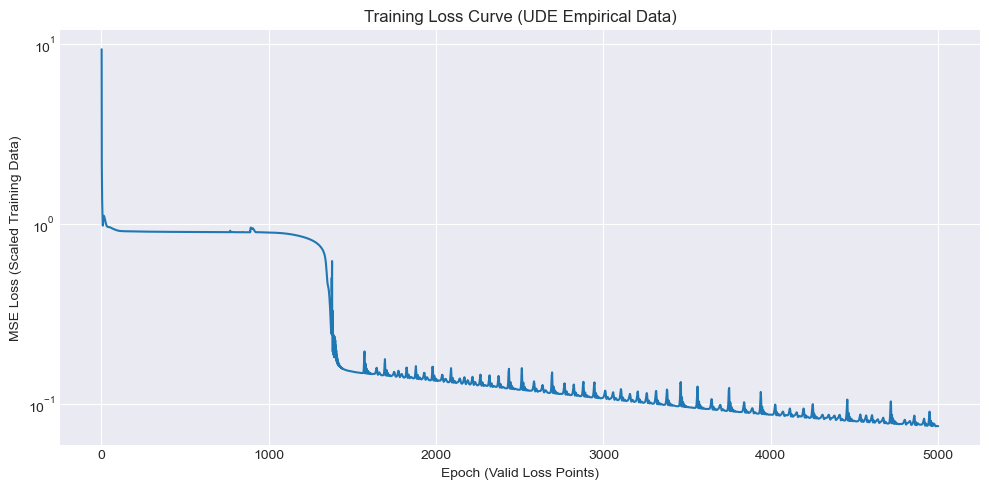

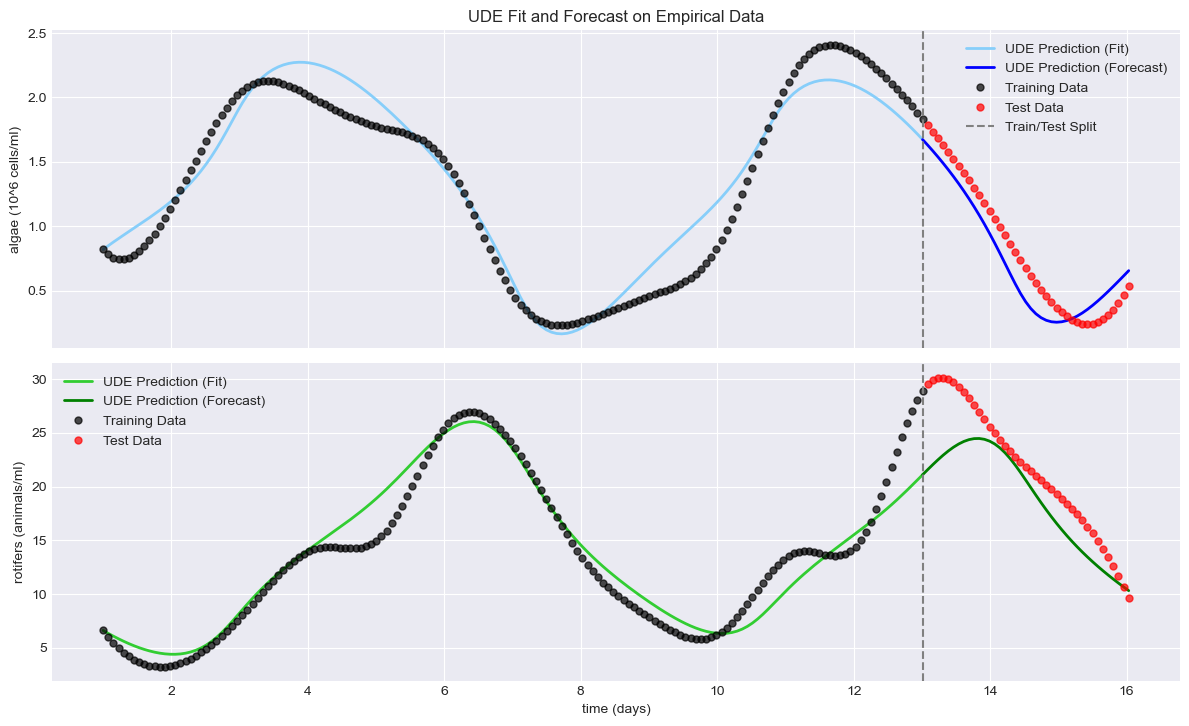

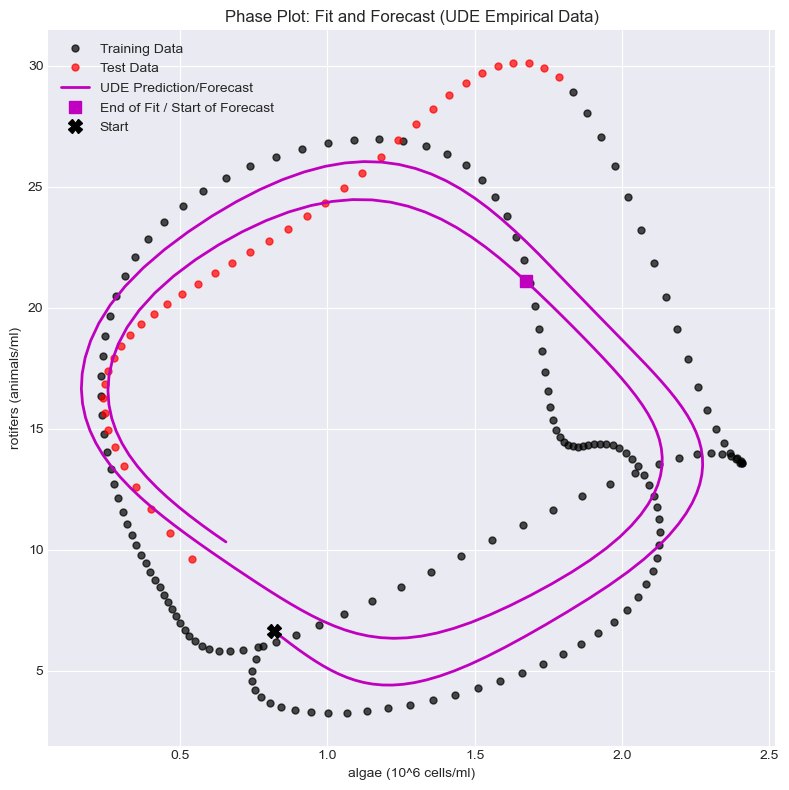

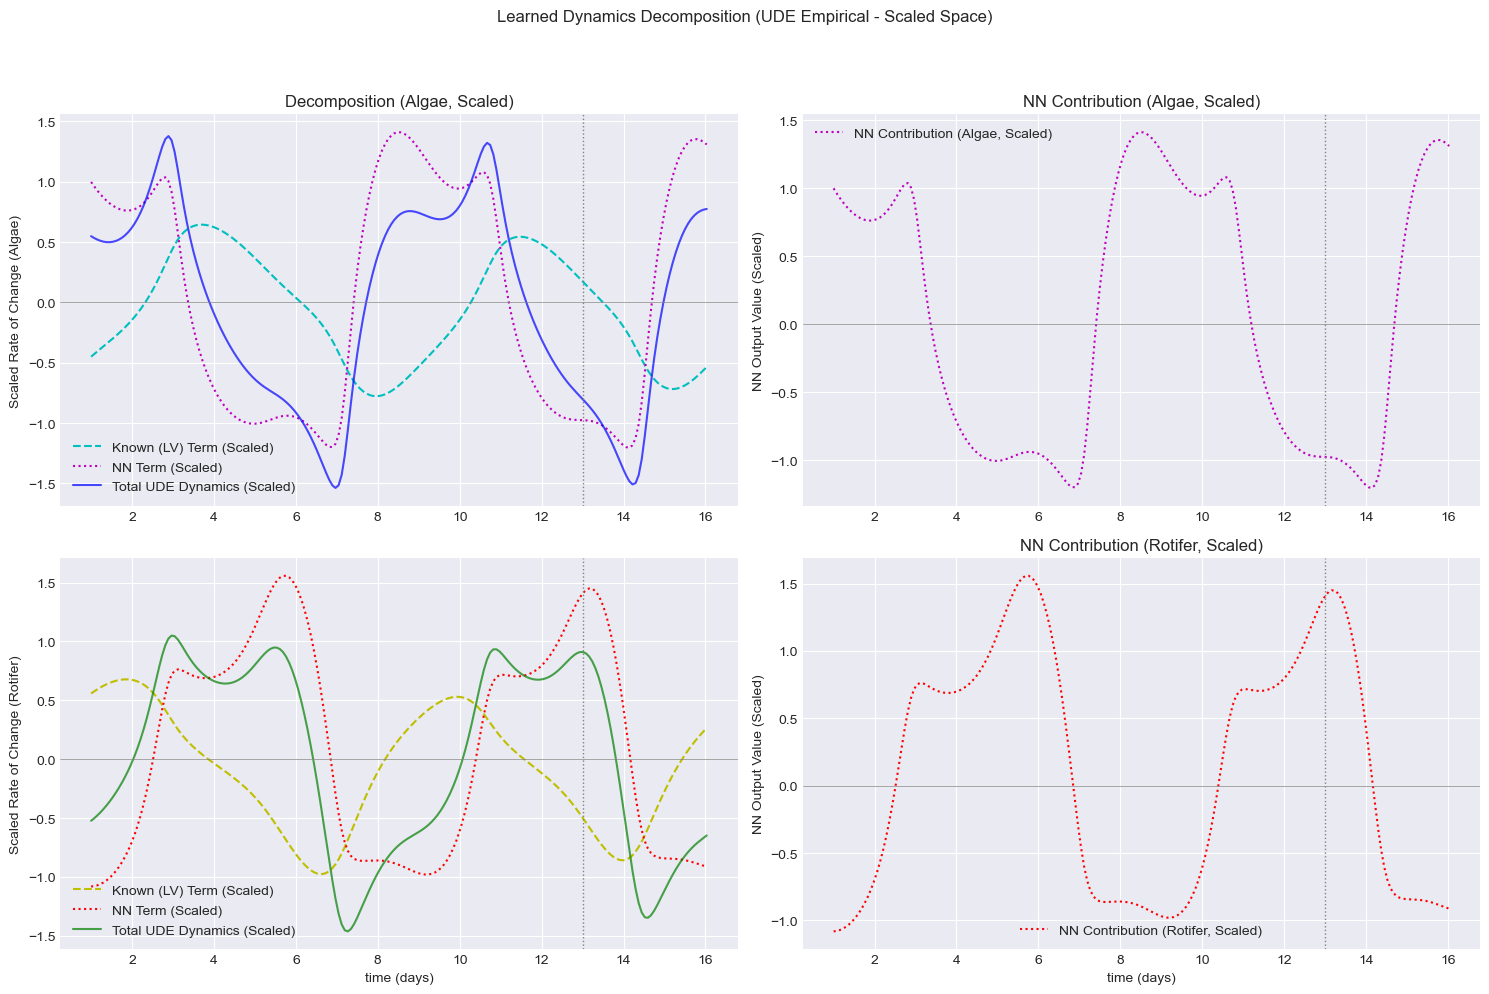


--- Script Finished ---


In [ ]:






def nrmse(y_true, y_pred):
    """Calculate Normalized Root Mean Squared Error (NRMSE) by range."""
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        return np.nan
    
    if np.isnan(y_true).any() or np.isnan(y_pred).any():
        return np.nan
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    data_range = np.max(y_true) - np.min(y_true)
    if data_range < 1e-8:
        return np.nan if rmse > 1e-8 else 0.0
    return rmse / data_range 

def smape(y_true, y_pred, epsilon=1e-8):
    """Calculate Symmetric Mean Absolute Percentage Error (sMAPE)."""
     
    if np.isnan(y_true).any() or np.isnan(y_pred).any():
        return np.nan
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    ratio = numerator / (denominator + epsilon)
    return np.mean(ratio) * 100.0 


print("\n--- Evaluating Model Fit (Train) and Forecast (Test) ---")
ude_func.eval()


u_pred_full_scaled_np = np.full((N_POINTS, 2), np.nan)
u_pred_full_np = np.full((N_POINTS, 2), np.nan)
u_pred_train_np = np.full((n_train, 2), np.nan)
u_pred_test_np = np.full((n_test, 2), np.nan)
u_pred_full_scaled = None 

with torch.no_grad():
    try:
        
        u_pred_full_scaled = torch_odeint(ude_func, u0, t_data, method=ODE_SOLVER, atol=1e-7, rtol=1e-7).to(device)
        u_pred_full_scaled_np = u_pred_full_scaled.cpu().numpy()

        
        print("Inverse transforming predictions to original scale for evaluation...")
        if np.isnan(u_pred_full_scaled_np).any() or np.isinf(u_pred_full_scaled_np).any():
             print("Error: Scaled predictions contain NaN or Inf. Cannot inverse transform or evaluate.")
             
        else:
            try:
                
                if 'scaler' in locals() and scaler is not None:
                    u_pred_full_np = scaler.inverse_transform(u_pred_full_scaled_np)
                    
                    u_pred_train_np = u_pred_full_np[:split_idx, :]
                    u_pred_test_np = u_pred_full_np[split_idx:, :]
                    print("Inverse transform successful.")
                else:
                    print("Error: Scaler object not found. Cannot inverse transform.")
                    u_pred_full_np.fill(np.nan) 
                    u_pred_train_np.fill(np.nan)
                    u_pred_test_np.fill(np.nan)
            except Exception as e:
                print(f"Error during inverse transform: {e}")
                u_pred_full_np.fill(np.nan) 
                u_pred_train_np.fill(np.nan)
                u_pred_test_np.fill(np.nan)

    except Exception as e:
        print(f"Error during evaluation (odeint): {e}")
        print("Predictions contain NaNs or evaluation failed.")


    
    print("\n--- Metrics Calculation (Original Scale) ---")
    metrics_train = {}
    metrics_test = {}

    
    if not (np.isnan(u_pred_full_np).any() or np.isinf(u_pred_full_np).any()):
        
        u_train_algae = u_train_np_orig[:, 0]
        u_train_rotifer = u_train_np_orig[:, 1]
        u_test_algae = u_test_np_orig[:, 0]
        u_test_rotifer = u_test_np_orig[:, 1]

        
        u_pred_train_algae = u_pred_train_np[:, 0]
        u_pred_train_rotifer = u_pred_train_np[:, 1]
        u_pred_test_algae = u_pred_test_np[:, 0]
        u_pred_test_rotifer = u_pred_test_np[:, 1]

        
        metrics_train['MSE_algae'] = mean_squared_error(u_train_algae, u_pred_train_algae)
        metrics_train['MSE_rotifer'] = mean_squared_error(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['MSE_total'] = mean_squared_error(u_train_np_orig, u_pred_train_np)
        metrics_train['RMSE_algae'] = np.sqrt(metrics_train['MSE_algae'])
        metrics_train['RMSE_rotifer'] = np.sqrt(metrics_train['MSE_rotifer'])
        metrics_train['RMSE_total'] = np.sqrt(metrics_train['MSE_total'])
        metrics_train['MAE_algae'] = mean_absolute_error(u_train_algae, u_pred_train_algae)
        metrics_train['MAE_rotifer'] = mean_absolute_error(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['MAE_total'] = mean_absolute_error(u_train_np_orig, u_pred_train_np)
        metrics_train['NRMSE_algae'] = nrmse(u_train_algae, u_pred_train_algae)
        metrics_train['NRMSE_rotifer'] = nrmse(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['sMAPE_algae'] = smape(u_train_algae, u_pred_train_algae)
        metrics_train['sMAPE_rotifer'] = smape(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['R2_algae'] = r2_score(u_train_algae, u_pred_train_algae)
        metrics_train['R2_rotifer'] = r2_score(u_train_rotifer, u_pred_train_rotifer)
        metrics_train['R2_total'] = r2_score(u_train_np_orig, u_pred_train_np)

        
        metrics_test['MSE_algae'] = mean_squared_error(u_test_algae, u_pred_test_algae)
        metrics_test['MSE_rotifer'] = mean_squared_error(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['MSE_total'] = mean_squared_error(u_test_np_orig, u_pred_test_np)
        metrics_test['RMSE_algae'] = np.sqrt(metrics_test['MSE_algae'])
        metrics_test['RMSE_rotifer'] = np.sqrt(metrics_test['MSE_rotifer'])
        metrics_test['RMSE_total'] = np.sqrt(metrics_test['MSE_total'])
        metrics_test['MAE_algae'] = mean_absolute_error(u_test_algae, u_pred_test_algae)
        metrics_test['MAE_rotifer'] = mean_absolute_error(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['MAE_total'] = mean_absolute_error(u_test_np_orig, u_pred_test_np)
        metrics_test['NRMSE_algae'] = nrmse(u_test_algae, u_pred_test_algae)
        metrics_test['NRMSE_rotifer'] = nrmse(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['sMAPE_algae'] = smape(u_test_algae, u_pred_test_algae)
        metrics_test['sMAPE_rotifer'] = smape(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['R2_algae'] = r2_score(u_test_algae, u_pred_test_algae)
        metrics_test['R2_rotifer'] = r2_score(u_test_rotifer, u_pred_test_rotifer)
        metrics_test['R2_total'] = r2_score(u_test_np_orig, u_pred_test_np)

        
        print("\n--- Training Set Metrics (Fit Performance, Original Scale) ---")
        print(f"  Metric       |   Algae   |  Rotifer  |   Total   ")
        print(f"----------------------------------------------------")
        print(f"  MSE          | {metrics_train['MSE_algae']:<9.4f} | {metrics_train['MSE_rotifer']:<9.4f} | {metrics_train['MSE_total']:<9.4f}")
        print(f"  RMSE         | {metrics_train['RMSE_algae']:<9.4f} | {metrics_train['RMSE_rotifer']:<9.4f} | {metrics_train['RMSE_total']:<9.4f}")
        print(f"  MAE          | {metrics_train['MAE_algae']:<9.4f} | {metrics_train['MAE_rotifer']:<9.4f} | {metrics_train['MAE_total']:<9.4f}")
        print(f"  NRMSE (range)| {metrics_train['NRMSE_algae']:<9.4f} | {metrics_train['NRMSE_rotifer']:<9.4f} |    N/A    ")
        print(f"  sMAPE (%)    | {metrics_train['sMAPE_algae']:<9.2f} | {metrics_train['sMAPE_rotifer']:<9.2f} |    N/A    ")
        print(f"  R^2          | {metrics_train['R2_algae']:<9.4f} | {metrics_train['R2_rotifer']:<9.4f} | {metrics_train['R2_total']:<9.4f}")

        print("\n--- Test Set Metrics (Forecast Performance, Original Scale) ---")
        print(f"  Metric       |   Algae   |  Rotifer  |   Total   ")
        print(f"----------------------------------------------------")
        print(f"  MSE          | {metrics_test['MSE_algae']:<9.4f} | {metrics_test['MSE_rotifer']:<9.4f} | {metrics_test['MSE_total']:<9.4f}")
        print(f"  RMSE         | {metrics_test['RMSE_algae']:<9.4f} | {metrics_test['RMSE_rotifer']:<9.4f} | {metrics_test['RMSE_total']:<9.4f}")
        print(f"  MAE          | {metrics_test['MAE_algae']:<9.4f} | {metrics_test['MAE_rotifer']:<9.4f} | {metrics_test['MAE_total']:<9.4f}")
        print(f"  NRMSE (range)| {metrics_test['NRMSE_algae']:<9.4f} | {metrics_test['NRMSE_rotifer']:<9.4f} |    N/A    ")
        print(f"  sMAPE (%)    | {metrics_test['sMAPE_algae']:<9.2f} | {metrics_test['sMAPE_rotifer']:<9.2f} |    N/A    ")
        print(f"  R^2          | {metrics_test['R2_algae']:<9.4f} | {metrics_test['R2_rotifer']:<9.4f} | {metrics_test['R2_total']:<9.4f}")
        print("-" * 52)

    else:
        print("Skipping metrics calculation due to NaN/Inf in predictions.")


    
    
    if 'best_model_state' in locals() and best_model_state is not None:
        try:
            
            
            learned_params = torch.exp(ude_func.known_model.log_params).cpu().numpy()
            print("\nLearned LV Parameters (from KnownDynamics component):")
            
            print(f"  alpha (Algae growth):    {learned_params[0]:<8.4f}")
            print(f"  beta (Algae predation):  {learned_params[1]:<8.4f}")
            print(f"  gamma (Rotifer death):   {learned_params[2]:<8.4f}")
            print(f"  delta (Rotifer growth):  {learned_params[3]:<8.4f}")
        except Exception as e:
             print(f"Could not retrieve learned parameters: {e}")
    else:
        print("\nSkipping learned parameter printout as no valid model state was loaded.")




print("\n--- Generating Plots (Original Scale with Split Color Forecast) ---")
plt.style.use('seaborn-v0_8-darkgrid')

split_time = t_train_np[-1] if 't_train_np' in locals() and len(t_train_np) > 0 else None


plt.figure(1, figsize=(10, 5))

if 'losses' in locals() and losses and not np.all(np.isnan(losses)):
    valid_losses = [l for l in losses if not np.isnan(l)]
    if valid_losses:
        plt.plot(range(1, len(valid_losses) + 1), valid_losses)
        plt.xlabel("Epoch (Valid Loss Points)")
    else:
        plt.xlabel("Epoch")
else:
     plt.xlabel("Epoch")
plt.ylabel("MSE Loss (Scaled Training Data)")
plt.title("Training Loss Curve (UDE Empirical Data)")
plt.yscale('log')
plt.tight_layout()


fig_ts, axs_ts = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fit_color_algae = 'lightskyblue'; forecast_color_algae = 'blue'
fit_color_rotifer = 'limegreen'; forecast_color_rotifer = 'green'



plot_ok = (
    't_train_np' in locals() and 't_test_np' in locals() and
    'u_train_np_orig' in locals() and 'u_test_np_orig' in locals() and
    not np.isnan(u_pred_train_np).any() and not np.isnan(u_pred_test_np).any()
)

if plot_ok:
    t_forecast_plot = np.concatenate(([t_train_np[-1]], t_test_np))
    u_pred_forecast_plot_algae = np.concatenate(([u_pred_train_np[-1, 0]], u_pred_test_np[:, 0]))
    u_pred_forecast_plot_rotifer = np.concatenate(([u_pred_train_np[-1, 1]], u_pred_test_np[:, 1]))
    
    axs_ts[0].plot(t_train_np, u_pred_train_np[:, 0], color=fit_color_algae, linestyle='-', linewidth=2, label='UDE Prediction (Fit)')
    axs_ts[0].plot(t_forecast_plot, u_pred_forecast_plot_algae, color=forecast_color_algae, linestyle='-', linewidth=2, label='UDE Prediction (Forecast)')
    
    axs_ts[1].plot(t_train_np, u_pred_train_np[:, 1], color=fit_color_rotifer, linestyle='-', linewidth=2, label='UDE Prediction (Fit)')
    axs_ts[1].plot(t_forecast_plot, u_pred_forecast_plot_rotifer, color=forecast_color_rotifer, linestyle='-', linewidth=2, label='UDE Prediction (Forecast)')
else:
    print("Skipping prediction line plotting in Time Series plot due to NaNs or missing data.")


if 't_train_np' in locals() and 'u_train_np_orig' in locals():
     axs_ts[0].plot(t_train_np, u_train_np_orig[:, 0], 'ko', markersize=5, alpha=0.7, label='Training Data')
     axs_ts[1].plot(t_train_np, u_train_np_orig[:, 1], 'ko', markersize=5, alpha=0.7, label='Training Data')
if 't_test_np' in locals() and 'u_test_np_orig' in locals():
    axs_ts[0].plot(t_test_np, u_test_np_orig[:, 0], 'ro', markersize=5, alpha=0.7, label='Test Data')
    axs_ts[1].plot(t_test_np, u_test_np_orig[:, 1], 'ro', markersize=5, alpha=0.7, label='Test Data')

if split_time is not None:
    axs_ts[0].axvline(split_time, color='gray', linestyle='--', linewidth=1.5, label='Train/Test Split')
    axs_ts[1].axvline(split_time, color='gray', linestyle='--', linewidth=1.5)

axs_ts[0].set_ylabel(prey_col); axs_ts[0].legend(loc='best'); axs_ts[0].set_title("UDE Fit and Forecast on Empirical Data")
axs_ts[1].set_ylabel(predator_col); axs_ts[1].set_xlabel(time_col); axs_ts[1].legend(loc='best')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])



plt.figure(3, figsize=(8, 8))

if 'u_train_np_orig' in locals():
    plt.plot(u_train_np_orig[:, 0], u_train_np_orig[:, 1], 'ko', markersize=5, alpha=0.7, label='Training Data')
if 'u_test_np_orig' in locals():
     plt.plot(u_test_np_orig[:, 0], u_test_np_orig[:, 1], 'ro', markersize=5, alpha=0.7, label='Test Data')


if not np.isnan(u_pred_full_np).any():
    plt.plot(u_pred_full_np[:, 0], u_pred_full_np[:, 1], 'm-', linewidth=2, label='UDE Prediction/Forecast')
    if not np.isnan(u_pred_train_np).any(): 
        plt.plot(u_pred_train_np[-1, 0], u_pred_train_np[-1, 1], 'ms', markersize=8, label='End of Fit / Start of Forecast')
    
    if 'u0' in locals() and 'scaler' in locals() and not np.isnan(u0.cpu().numpy()).any():
         try:
            u0_orig = scaler.inverse_transform(u0.cpu().numpy().reshape(1, -1))[0]
            plt.plot(u0_orig[0], u0_orig[1], 'kX', markersize=10, label='Start')
         except Exception as e: print(f"Could not plot original start point: {e}")
else: print("Skipping prediction line plotting in Phase plot due to NaNs.")
plt.xlabel(prey_col); plt.ylabel(predator_col); plt.title("Phase Plot: Fit and Forecast (UDE Empirical Data)")
plt.legend(); plt.grid(True); plt.tight_layout()



print("\n--- Visualizing Learned Dynamics (Full Trajectory, Scaled Space) ---")

if 'u_pred_full_scaled_np' in locals() and not (np.isnan(u_pred_full_scaled_np).any() or np.isinf(u_pred_full_scaled_np).any()):
    
    if u_pred_full_scaled is not None:
        with torch.no_grad():
            known_dyn_pred_scaled = torch.zeros_like(u_pred_full_scaled)
            nn_dyn_pred_scaled = torch.zeros_like(u_pred_full_scaled)
            for i in range(len(t_data)):
                u_i_scaled = u_pred_full_scaled[i].unsqueeze(0)
                t_i = t_data[i]
                known_dyn_pred_scaled[i] = ude_func.known_model(t_i, u_i_scaled).squeeze(0)
                nn_dyn_pred_scaled[i] = ude_func.neural_net(u_i_scaled).squeeze(0)

            known_dyn_np_scaled = known_dyn_pred_scaled.cpu().numpy()
            nn_dyn_np_scaled = nn_dyn_pred_scaled.cpu().numpy()
            total_dyn_np_scaled = known_dyn_np_scaled + nn_dyn_np_scaled

            
            fig_decomp, axs_decomp = plt.subplots(2, 2, figsize=(15, 10))
            
            axs_decomp[0, 0].plot(t_data_np_full, known_dyn_np_scaled[:, 0], 'c--', label='Known (LV) Term (Scaled)')
            axs_decomp[0, 0].plot(t_data_np_full, nn_dyn_np_scaled[:, 0], 'm:', label='NN Term (Scaled)')
            axs_decomp[0, 0].plot(t_data_np_full, total_dyn_np_scaled[:, 0], 'b-', alpha=0.7, label='Total UDE Dynamics (Scaled)')
            if split_time is not None: axs_decomp[0, 0].axvline(split_time, color='gray', linestyle=':', linewidth=1)
            axs_decomp[0, 0].set_ylabel("Scaled Rate of Change (Algae)"); axs_decomp[0, 0].legend(); axs_decomp[0, 0].set_title("Decomposition (Algae, Scaled)")
            axs_decomp[0, 0].axhline(0, color='gray', lw=0.5); axs_decomp[0, 0].grid(True)

            axs_decomp[1, 0].plot(t_data_np_full, known_dyn_np_scaled[:, 1], 'y--', label='Known (LV) Term (Scaled)')
            axs_decomp[1, 0].plot(t_data_np_full, nn_dyn_np_scaled[:, 1], 'r:', label='NN Term (Scaled)')
            axs_decomp[1, 0].plot(t_data_np_full, total_dyn_np_scaled[:, 1], 'g-', alpha=0.7, label='Total UDE Dynamics (Scaled)')
            if split_time is not None: axs_decomp[1, 0].axvline(split_time, color='gray', linestyle=':', linewidth=1)
            axs_decomp[1, 0].set_ylabel("Scaled Rate of Change (Rotifer)"); axs_decomp[1, 0].set_xlabel(time_col)
            axs_decomp[1, 0].legend(); axs_decomp[1, 0].axhline(0, color='gray', lw=0.5); axs_decomp[1, 0].grid(True)

            axs_decomp[0, 1].plot(t_data_np_full, nn_dyn_np_scaled[:, 0], 'm:', label='NN Contribution (Algae, Scaled)')
            if split_time is not None: axs_decomp[0, 1].axvline(split_time, color='gray', linestyle=':', linewidth=1)
            axs_decomp[0, 1].set_ylabel("NN Output Value (Scaled)"); axs_decomp[0, 1].legend(); axs_decomp[0, 1].set_title("NN Contribution (Algae, Scaled)")
            axs_decomp[0, 1].axhline(0, color='gray', lw=0.5); axs_decomp[0, 1].grid(True)

            axs_decomp[1, 1].plot(t_data_np_full, nn_dyn_np_scaled[:, 1], 'r:', label='NN Contribution (Rotifer, Scaled)')
            if split_time is not None: axs_decomp[1, 1].axvline(split_time, color='gray', linestyle=':', linewidth=1)
            axs_decomp[1, 1].set_ylabel("NN Output Value (Scaled)"); axs_decomp[1, 1].set_xlabel(time_col)
            axs_decomp[1, 1].legend(); axs_decomp[1, 1].set_title("NN Contribution (Rotifer, Scaled)")
            axs_decomp[1, 1].axhline(0, color='gray', lw=0.5); axs_decomp[1, 1].grid(True)

            plt.suptitle("Learned Dynamics Decomposition (UDE Empirical - Scaled Space)", y=1.02)
            plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    else:
         print("Skipping dynamics decomposition plot as scaled predictions needed for calculation are missing/invalid.")
else:
    print("Skipping dynamics decomposition plot due to NaN/Inf in scaled predictions.")


if plt.get_fignums():
    plt.show()
else:
    print("No plots were generated.")

print("\n--- Script Finished ---")